# Cost sensitive approaches
**Methods will modifies the learning function**

**1. Cost of misclassifying obs**
- __Cost of misclassifying__ of specific class is the prediction errors of this class
- Thông thường các thuật toán sẽ không phân biệt error rate của từng class mà sẽ là chung của tất cả các class, với asumption là all misclassification errors có chi phí bằng nhau ở các class. Khi áp dụng cost of misclassification, tức quan tâm tới sự khác biệt về `error-rate` của từng class. Ví dụ: Chi phí của phân loại khách hàng __BAD__ thành __GOOD__ cao hơn cost phân loại sai khách hành __GOOD__ thành __BAD__
- **Cost sensitive learning (CSL)** là 1 dạng learning mà sẽ đo lường __Cost of misclassifying__, với mục tiêu là minimize the total cost (cost in each class is differently)
- So sánh **Cost sensitive** với **Cost insensitive learning**

|Cost insensitive|Cost sensitive|
|-----|-----|
|Minimize error-rate|Minimize cost|
|Same cost to all misclassification|Different misclassification cost|

**2. Cost Matrix**

<img src="_images/02cs_costsen.png">

**3. Obtaining the Cost**

There are 2 ways of estimating the cost:

- `Domain Expert` provides the cost (depend on knowledge/business)
- `Balance Ratio`: set **class_weight** or **sample_weight** parameter to indicate that the loss function should be modified to accommodate the class imbalance and the cost attributed to each misclassification, find cost as hyper-parameter

## BasicCost

- **class_weight**: can take 'balanced' as argument, in which case it will use the balance ratio as weight. Alternatively, it can take a dictionary with {class: penalty}, pairs. In this case, it penalizes mistakes in samples of class[i] with class_weight[i]. For instances, class_weight = {0:1, and 1:10}, misclassification of observations of class 1 are penalized 10 times more than misclassification of observations of class 0.
- **sample_weight** is a vector of the same length as y, containing the weight or penalty for each individual observation. In principle, it is more flexible, because it allows us to set weights to the observations and not to the class as a whole. So in this case, for example we could set up higher penalties for fraudulent applications that are more costly (money-wise)than to those fraudulent applications that are of little money.

In [34]:
from sklearn.linear_model import LogisticRegression

# weights introduced here
logit = LogisticRegression(
        penalty='l2',
        solver='newton-cg',
        random_state=0,
        max_iter=10,
        n_jobs=4,
        class_weight={0:1, 1:10} # weights / cost
    )

## MetaCost

**1. Conditional Risk - Expected Cost**
EC của quan sát x theo class i được định nghĩa là giá trị average có weight của tất cả các cost được assign của x theo all classes thành class i.
$$R(i|x)=\sum_{j=1}^{M}P(j|x)\cdot C(i,j)$$
in which:
- $R(i|x)$ is the expected cose of classifying an observation x into class i
- $P(j|x)$ is the probability of x of being of class j
- $C(i,j)$ is the cost of assigning an observation x of class j to class i

__Conclusion__: For observation x, x will classify belong to class 1 if and only if `R(1|x) <= R(0|x)` or $\frac{C(1,0)}{C(1,0) + C(0,1)}$ <= P(1|x)

Bởi vì almost các thuật toán sklearn sử dụng __insensitive cost__, nên nếu muốn chuyển đổi sang __sensitive cost__ (__MetaCost__), sử dụng `predict_prob` để lấy xác suất __P(1|x)__, kết hợp với cost đã assign giúp xác định observation nào sẽ được phân loại theo class 1 theo __Conclusion__ ở trên.

**2. MetaCost**

__MetaCost__ change the original label to the new, then get new dataset to use for any algorithms, i.e. use `bagging multi-classifiers` to get probabilities of each class, combine these with `Cost`, then re-labels the target `Y` to the  new class that has a minimises the `conditional risk (EC)`, and finally we have a new dataset (new label) to train the ML that we want.
__MetaCost__ is a procedure to make cost insenstitve algorithm, cost sensitive, which applied to any algorithm whether it returns probabilities or classes

- __Parameter__ for `Metacost`:
    - `S` : training set
    - `L` : Classsification learning algorithm
    - `C` : cost matrix
    - `m` : the number of resamples to generate
    - `n` : the number of examples in each resample
    - `p` : is True if L produces class pprobabilities
    - `q` : is True if all resamples are to be used for each example
   
<img src="_images/02cs_meta_cost.png">

In [35]:
import numpy as np
import pandas as pd

from sklearn.base import clone


class MetaCost:
    """A procedure for making error-based classifiers cost-sensitive

    Adapted from https://github.com/Treers/MetaCost/blob/master/MetaCost.py

    .. note:: The form of the cost matrix C must be as follows:
    +---------------+----------+----------+----------+
    |  actual class |          |          |          |
    +               |          |          |          |
    |   +           | y(x)=j_1 | y(x)=j_2 | y(x)=j_3 |
    |       +       |          |          |          |
    |           +   |          |          |          |
    |predicted class|          |          |          |
    +---------------+----------+----------+----------+
    |   h(x)=j_1    |    0     |    a     |     b    |
    |   h(x)=j_2    |    c     |    0     |     d    |
    |   h(x)=j_3    |    e     |    f     |     0    |
    +---------------+----------+----------+----------+
    | C = np.array([[0, a, b],[c, 0 , d],[e, f, 0]]) |
    +------------------------------------------------+
    """

    def __init__(self, estimator, cost_matrix, n_estimators=50, n_samples=None, p=True, q=True):
        """
        Parameters
        ----------
        estimator :
            An sklearn classifier
        cost_matrix :
            The cost matrix
        n_estimators :
            The number of estimators in the ensemble
        n_samples :
            The number of samples to train each estimator
        p :
            Is True if the estimator produces class probabilities. False otherwise
        q :
            True if all samples are to be used for each example
        """

        self.estimator = estimator
        self.cost_matrix = cost_matrix
        self.n_estimators = n_estimators
        self. n_samples = n_samples
        self.p = p
        self.q = q

    def fit(self, X, y):
        """
        Parameters
        ----------
        X :
            Training set
        y :
            Target
        """

        if not isinstance(X, pd.DataFrame):
            raise ValueError('S must be a DataFrame object')

        X = X.copy()

        # reset index, helps with resampling
        X.reset_index(inplace=True, drop=True)
        y.index = X.index

        variables = list(X.columns)

        # concatenate
        S = pd.concat([X,y], axis=1)
        S.columns = variables + ['target']

        num_class = y.nunique()

        if not self.n_samples:
            self.n_samples = len(X)

        S_ = {} # list of subdatasets
        M = []  # list of models

        print('resampling data and training ensemble')
        for i in range(self.n_estimators):

            # Let S_[i] be a resample of S with self.n examples
            S_[i] = S.sample(n=self.n_samples, replace=True)

            X = S_[i][variables].values
            y = S_[i]['target'].values

            # Let M[i] = model produced by applying L to S_[i]
            model = clone(self.estimator)
            M.append(model.fit(X, y))

        print('Finished training ensemble')

        label = []
        S_array = S[variables].values
        # for each observation
        print('evaluating optimal class per observation')
        for i in range(len(S)):
            if self.q:
                # consider the predictions of all models
                M_ = M
            else:
                # consider the predictions of models which were not train on
                # this particular observation
                k_th = [k for k, v in S_.items() if i not in v.index]
                M_ = list(np.array(M)[k_th])

            if self.p:
                P_j = [model.predict_proba(S_array[[i]]) for model in M_]
            else:
                P_j = []
                vector = [0] * num_class
                for model in M_:
                    vector[model.predict(S_array[[i]])] = 1
                    P_j.append(vector)

            # Calculate P(j|x)
            # the average probability of each class, when combining all models
            P = np.array(np.mean(P_j, 0)).T

            # Relabel:
            label.append(np.argmin(self.cost_matrix.dot(P)))
        print('Finished re-assigning labels')

        # Model produced by applying L to S with relabeled y
        print('Training model on new data')
        X_train = S[variables].values
        y_train = np.array(label)
        self.estimator.fit(X_train, y_train)
        print('Finished training model on data with new labels')
        self.y_ = pd.Series(label)

    def predict(self, X):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        try:
            probs = self.estimator.predict_proba(X)
        except:
            probs = None
            print('this estimator does not support predict_proba')
        return probs

<AxesSubplot: ylabel='target'>

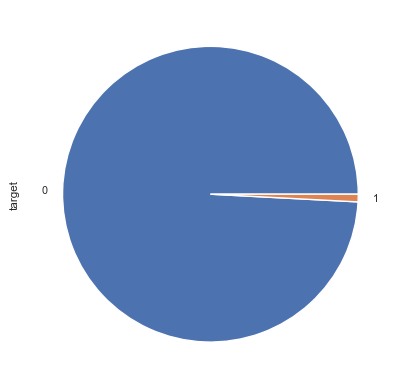

In [36]:
# load data
# only a few observations to speed the computaton
data = pd.read_csv('Datasets/kdd2004.csv').sample(10000)

# imbalanced target
data.target.value_counts().plot(kind = 'pie')

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

# set up the estimator we would like to ensemble
logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    random_state=0,
    max_iter=20,
)

In [40]:
# no cost (similar normal with no metacost)

metacost_nocost = MetaCost(estimator=logit,
                     cost_matrix=np.array([[0, 1], [1, 0]]),
                     n_estimators=50,
                     n_samples=None,
                     p=True,
                     q=True)
metacost_nocost.fit(X_train, y_train)
# metacost_.predict_proba(X_train)


print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_train, metacost_nocost.predict_proba(X_train)[:, 1])))
print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_test, metacost_nocost.predict_proba(X_test)[:, 1])))
confusion_matrix(y_test, metacost_nocost.predict(X_test))

resampling data and training ensemble
Finished training ensemble
evaluating optimal class per observation
Finished re-assigning labels
Training model on new data
Finished training model on data with new labels
Train set, MetaCost roc-auc: 0.9490451674621461
Train set, MetaCost roc-auc: 0.8632507381246028


array([[2973,    0],
       [  11,   16]])

In [41]:
# Metacost
"""
TN | FN
FP | TP

cost
0 | 100
1 | 0
"""
metacost_ = MetaCost(estimator=logit,
                     cost_matrix=np.array([[0, 100], [1, 0]]),
                     n_estimators=50,
                     n_samples=None,
                     p=True,
                     q=True)
metacost_.fit(X_train, y_train)
# metacost_.predict_proba(X_train)


print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_train, metacost_.predict_proba(X_train)[:, 1])))
print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_test, metacost_.predict_proba(X_test)[:, 1])))
confusion_matrix(y_test, metacost_.predict(X_test))

resampling data and training ensemble
Finished training ensemble
evaluating optimal class per observation
Finished re-assigning labels
Training model on new data
Finished training model on data with new labels
Train set, MetaCost roc-auc: 0.9924060854180382
Train set, MetaCost roc-auc: 0.9241942918364042


array([[2797,  176],
       [   7,   20]])

In [42]:
# compare with basicCost by parameter class_weight
logit_cost = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    random_state=0,
    max_iter=10,
    n_jobs=4,
    class_weight = {0:1, 1:100},
)

logit_cost.fit(X_train, y_train)

print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_train, logit_cost.predict_proba(X_train)[:, 1])))
print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_test, logit_cost.predict_proba(X_test)[:, 1])))
confusion_matrix(y_test, logit_cost.predict(X_test))

Train set, MetaCost roc-auc: 0.9941046226958525
Train set, MetaCost roc-auc: 0.9232101256991939


/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


array([[2841,  132],
       [   8,   19]])

lowest FN

In [43]:
# compare with logistic normal
logit.fit(X_train, y_train)
print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_train, logit.predict_proba(X_train)[:, 1])))
print('Train set, MetaCost roc-auc: {}'.format(roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])))
confusion_matrix(y_test, logit.predict(X_test))

Train set, MetaCost roc-auc: 0.9914314516129032
Train set, MetaCost roc-auc: 0.9283801123693488


array([[2971,    2],
       [  14,   13]])